In [1]:
import sys
sys.path.append('../')
from matplotlib import rcParams
rcParams['font.family'] = 'SimHei'
%matplotlib inline
import backtrader as bt

In [2]:
from datafeed.dataloader import CSVDataloader
df = CSVDataloader.get_backtrader_df('000300.SH',start_date='20050101',end_date='20170430')
df.dropna()

,open,high,low,close,volume,openinterest
date,,,,,,
2005-01-04,994.7690,994.7690,980.6580,982.7940,7.412869e+06,0
2005-01-05,981.5770,997.3230,979.8770,992.5640,7.119109e+06,0
2005-01-06,993.3310,993.7880,980.3300,983.1740,6.288029e+06,0
2005-01-07,983.0450,995.7110,979.8120,983.9580,7.298694e+06,0
2005-01-10,983.7600,993.9590,979.7890,993.8790,5.791698e+06,0
...,...,...,...,...,...,...
2017-04-24,3458.2279,3458.2279,3403.9792,3431.2587,1.146608e+08,0
2017-04-25,3427.7322,3449.6716,3422.6521,3440.9743,9.407215e+07,0
2017-04-26,3440.2526,3466.5651,3439.1505,3445.1832,1.119400e+08,0


In [3]:
from backtrader_indicators import RSRS,RSRS_Norm
class MyStrategy_RSRS(bt.Strategy): # RSRS
    # 参数定义
    params = dict(
        period=18,  # RSRS周期
    )

    def __init__(self):
        self.rsrs = RSRS(self.data, N=self.p.period)
        self.rsrs_norm = RSRS_Norm(self.data, N=self.p.period)
    
    def next(self):
        if not self.position:  # not in the market
            if self.rsrs.lines.rsrs[0] > 1: 
                self.order_target_percent(self.data,0.99)  # enter long

        elif self.rsrs.lines.rsrs[0] < 0.8:  
            self.close()  # close long position
            
class MyStrategy(bt.Strategy): #RSRS标准分
    # 参数定义
    params = dict(
        period=18,  # RSRS周期
    )

    def __init__(self):
        self.rsrs = RSRS(self.data, N=self.p.period)
        self.rsrs_norm = RSRS_Norm(self.data, N=self.p.period)
    
    def next(self):
        if not self.position:  # not in the market
            if self.rsrs_norm[0] > 0.7: 
                self.order_target_percent(self.data,0.99)  # enter long

        elif self.rsrs_norm[0] < -0.7:
            self.close()  # close long position

In [4]:
cerebro = bt.Cerebro()
cerebro.broker.setcash(100*10000.0)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

data = bt.feeds.PandasData(dataname=df)
cerebro.adddata(data)


print('初始资金: %.2f' % cerebro.broker.getvalue())
cerebro.addstrategy(MyStrategy_RSRS)
#cerebro.addstrategy(MyStrategy)
results = cerebro.run()

print('期末资金: %.2f' % cerebro.broker.getvalue())

初始资金: 1000000.00
期末资金: 3594249.58


In [5]:
for ret in results:
    print(ret)
    pyfolio = ret.analyzers.getbyname('pyfolio')
    returns, positions, transactions, gross_lev = pyfolio.get_pf_items()
    import empyrical as em
    rets = em.annual_return(returns)
    print(rets)
    #PnL = round(strategy.broker.get_value() - 10000, 2)
    #sharpe = strategy.analyzers.sharpe_ratio.get_analysis()
    
        

0.11377093510551606


In [6]:
strat0 = results[0]
s = results[0]
pyfolio = s.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfolio.get_pf_items()
import empyrical as em
print('年化回报',em.annual_return(returns))

年化回报 0.11377093510551606


In [7]:
import quantstats as qs
qs.reports.metrics(returns)

                    Strategy
------------------  ----------
Start Period        2005-01-04
End Period          2017-04-28
Risk-Free Rate      0.0%
Time in Market      37.0%

Cumulative Return   259.42%
CAGR﹪              7.43%

Sharpe              0.73
Prob. Sharpe Ratio  99.4%
Sortino             1.09
Sortino/√2          0.77
Omega               1.25

Max Drawdown        -50.1%
Longest DD Days     1008

Gain/Pain Ratio     0.25
Gain/Pain (1M)      1.1

Payoff Ratio        1.1
Profit Factor       1.25
Common Sense Ratio  1.74
CPC Index           0.73
Tail Ratio          1.4
Outlier Win Ratio   12.29
Outlier Loss Ratio  3.13

MTD                 0.0%
3M                  -0.52%
6M                  -1.78%
YTD                 0.83%
1Y                  -2.44%
3Y (ann.)           16.63%
5Y (ann.)           11.85%
10Y (ann.)          9.23%
All-time (ann.)     7.43%

Avg. Drawdown       -4.18%
Avg. Drawdown Days  71
Recovery Factor     2.88
Ulcer Index         0.11
Serenity Index      0.63


                    Strategy
------------------  ----------
Start Period        2005-01-04
End Period          2017-04-28
Risk-Free Rate      0.0%
Time in Market      37.0%

Cumulative Return   259.42%
CAGR﹪              7.43%

Sharpe              0.73
Prob. Sharpe Ratio  99.4%
Sortino             1.09
Sortino/√2          0.77
Omega               1.25

Max Drawdown        -50.1%
Longest DD Days     1008

Gain/Pain Ratio     0.25
Gain/Pain (1M)      1.1

Payoff Ratio        1.1
Profit Factor       1.25
Common Sense Ratio  1.74
CPC Index           0.73
Tail Ratio          1.4
Outlier Win Ratio   12.29
Outlier Loss Ratio  3.13

MTD                 0.0%
3M                  -0.52%
6M                  -1.78%
YTD                 0.83%
1Y                  -2.44%
3Y (ann.)           16.63%
5Y (ann.)           11.85%
10Y (ann.)          9.23%
All-time (ann.)     7.43%

Avg. Drawdown       -4.18%
Avg. Drawdown Days  71
Recovery Factor     2.88
Ulcer Index         0.11
Serenity Index      0.63


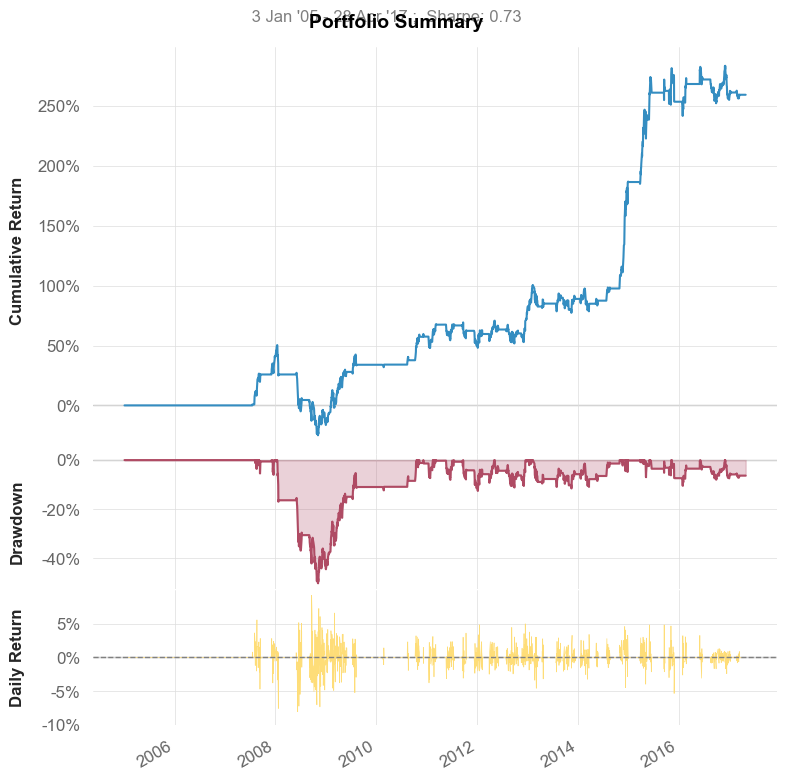

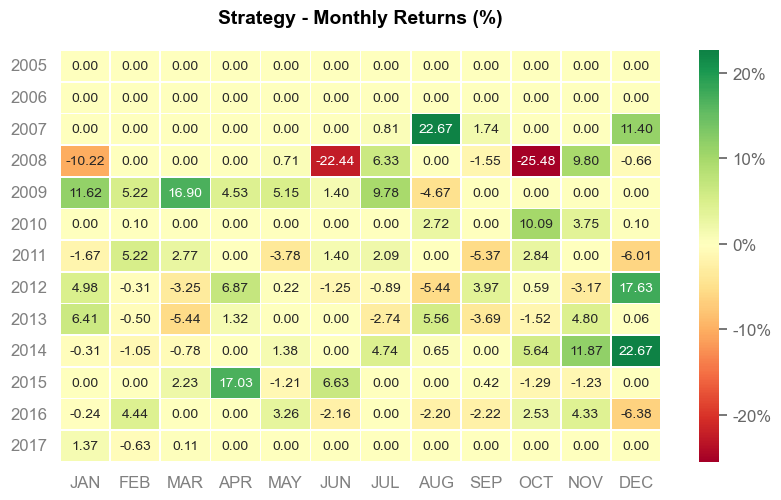

In [8]:
qs.reports.basic(returns)